# I used this script for the new 0.5 velocity data for the random trajectory

#### Generate Representations
In this notebook, we generate the inputs for the machine learning model. At the end of this notebook, we will have computed the features for all available data, and generated the pickle files needed to run these models for any available data.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints, ProjectileVelocity, TimeOffset
from stopping_power_ml.io import get_charge_density_interpolator
from matminer.featurizers.base import MultipleFeaturizer
from tqdm import tqdm_notebook as tqdm
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import sys
import os
import h5py

Configure Parsl

In [2]:
import parsl
#from parsl.configs.local_ipp import config
from parsl.configs.local_threads import config 
from parsl.app.app import python_app
dfk = parsl.load(config)

## Load in Dataset
Load in the pickled dataset from `parse-qbox-data`

In [33]:
data_1 = pkl.load(gzip.open('data_1.pkl.gz', 'rb'))
print('Loaded %d entries'%len(data_1))
data_1.columns


Loaded 222332 entries


Index(['frame_id', 'force', 'position', 'velocity', 'energy', 'file_id',
       'file', 'timestep', 'displacement', 'directory'],
      dtype='object')

In [4]:


h5f = h5py.File("new_random_data/random_v0.5.h5", "r")


data_list = []


keys = list(h5f.keys())

for k in keys:
    
    E = h5f[f'{k}/E'][:]        # Energy
    pos = h5f[f'{k}/pos'][:]     # Position 
    disp = h5f[f'{k}/disp'][:]   # Displacement
    vel = h5f[f'{k}/vel'][:]     # Velocity 
    force = h5f[f'{k}/sp'][:]    # Stopping force
    
    
    file_id = [k] * E.shape[0]
    
    
    for i in range(E.shape[0]):
        data_list.append({
            "file_id": file_id[i],
            "energy": E[i],
            "position": pos[i],   # Keep as 3-item array
            "displacement": disp[i],
            "velocity": vel[i],   # Keep as 3-item array
            "force": force[i]
        })

# Close the HDF5 file
h5f.close()

# Convert the list of dictionaries into a DataFrame
data_df = pd.DataFrame(data_list)

# Save the DataFrame to a .pkl file
with open("new_random_data.pkl", "wb") as f:
    pkl.dump(data_df, f)

print("Data has been saved to data.pkl")


In [5]:
new_random_data = pkl.load(open('new_random_data.pkl', 'rb'))
print('Loaded %d entries'%len(new_random_data))
new_random_data.columns
print(new_random_data['velocity'][0:-1])

Loaded 19502 entries
0          [0.3130462, 0.32071948, 0.22167794]
1          [0.3130462, 0.32071948, 0.22167794]
2          [0.3130462, 0.32071948, 0.22167794]
3          [0.3130462, 0.32071948, 0.22167794]
4          [0.3130462, 0.32071948, 0.22167794]
                         ...                  
19496    [-0.0988002, -0.20926218, -0.4432244]
19497    [-0.0988002, -0.20926218, -0.4432244]
19498    [-0.0988002, -0.20926218, -0.4432244]
19499    [-0.0988002, -0.20926218, -0.4432244]
19500    [-0.0988002, -0.20926218, -0.4432244]
Name: velocity, Length: 19501, dtype: object


Load an example of the simualtion cell

In [6]:
start_frame = pkl.load(open('Si_starting_frame.pkl', 'rb'))

## Compute the Representation
We use three kinds of features as input to our machine learning model:

1. *Local Charge Density*: The local electron density at the projectile's current position and several positions in the future and past.
1. *Local Environemnt*: Descriptions of the atom environment around the projectile using the AGNI fingerprints developed by [Botu *et al*](http://pubs.acs.org/doi/10.1021/acs.jpcc.6b10908)
1. *Ion-Ion Repulsion*: The Coulombic repulsion force between the Si atoms and the projectile

### Local Charge Density Features
These features are based on the ground-state electronic structure of Si, as computed using DFT. The original 

In [7]:
%%time
charge = pkl.load(open('density_12ePP_interp-nosym.pkl', 'rb'))

CPU times: user 6.21 ms, sys: 48.5 ms, total: 54.7 ms
Wall time: 351 ms


In [8]:
charge_features = TimeOffset(start_frame, LocalChargeDensity(start_frame, charge))

Compute the features. First, we define a parallel function with Parsl

In [9]:
def compute_features(featurizer, data, chunks=96):
    """Compute the features for each entry in the dataframe.
    
    :param featurizer: tool used to compute the features
    :param data: pd.DataFrame, data to be featurized
    :param threads_per_worker: int, number of threads to run on each Parsl worker
    :param chunks: int, number of pieces to evaluate in parallel"""
    
    featurizer.set_chunksize(None)
    return featurizer.featurize_dataframe(data, ['position', 'velocity'], pbar=False)

In [10]:
%%time
data = compute_features(charge_features, new_random_data)

CPU times: user 15.3 s, sys: 21.5 s, total: 36.7 s
Wall time: 1min 37s


Plot the variables on the random trajectory

In [35]:
#subset = data[data['directory'].str.contains('data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_1.5')]
print(type(data))
print(data.columns)
data.shape
#data['timestep'] = np.linespace(0,19502, 19503)

<class 'pandas.core.frame.DataFrame'>
Index(['file_id', 'energy', 'position', 'displacement', 'velocity', 'force',
       'charge density at t=-4.00', 'charge density at t=-3.00',
       'charge density at t=-2.00', 'charge density at t=-1.00',
       'charge density at t=-0.50', 'charge density at t=0.00',
       'charge density at t=0.50', 'charge density at t=1.00',
       'charge density at t=2.00'],
      dtype='object')


(19502, 15)

KeyError: 'timestep'

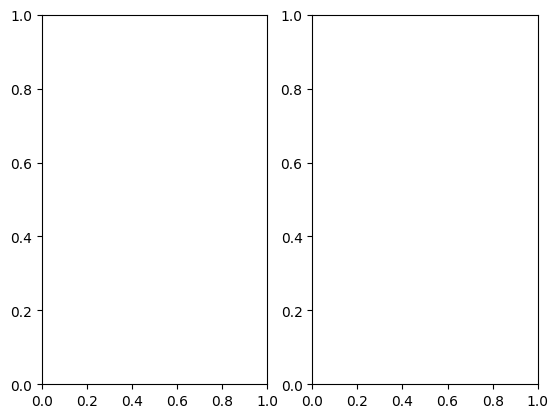

In [14]:
fig, ax = plt.subplots(1, 2)

labels = charge_features.feature_labels()
ax[0].plot(subset['timestep'], subset[labels], '-', label=labels)
ax[1].plot(subset['timestep'], subset[labels])

#ax.legend(labels)
ax[0].set_xlim(100, 300)
#ax[0].set_ylim(0, 1.5)
ax[1].set_xlim(0, 2000)
for a in ax:
    a.set_xlabel('Timestep')
ax[0].set_ylabel('Feature Value')
fig.set_size_inches(8, 4)

## Compute AGNI Fingerprints
Use these to describe the local enviroment around a particle

In [34]:
agni_features = ProjectedAGNIFingerprints(start_frame, etas=np.logspace(np.log10(0.8), np.log10(16), 8).tolist(),
                                          use_prim_cell=False)

In [36]:
%%time
#data = agni_features.featurize_dataframe(data, 'atoms')
data = compute_features(agni_features, data) # Turned off while writing this notebook

CPU times: user 830 ms, sys: 5.13 s, total: 5.96 s
Wall time: 1min 8s


## Compute Ion-Ion Interaction Forces
Get the repulsion force due to the ion-ion repulsion from the surrounding Al nuclei. Specifically, we compute the force acting on the particle in the direction of travel using the [Ewald summation method](https://en.wikipedia.org/wiki/Ewald_summation).

In [37]:
ewald_features = IonIonForce(start_frame, acc=4)

In [38]:
%%time
data = compute_features(ewald_features, data) 

CPU times: user 712 ms, sys: 5.46 s, total: 6.18 s
Wall time: 38.1 s


## Add Velocity as Feature
Just the magnitude of the projectile velocity

In [39]:
velocity_feature = ProjectileVelocity(start_frame)

In [40]:
%%time
data = compute_features(velocity_feature, data) 

CPU times: user 670 ms, sys: 4.32 s, total: 4.99 s
Wall time: 9.85 s


## Make a MultiFeaturizer
Will enable computing features in parallel slightly faster.

Also, for this project, we're going to skip the velocity feature

In [41]:
featurizer = MultipleFeaturizer([charge_features, agni_features, ewald_features])

## Save everything to disk
Data and featurizers

In [42]:
data.columns

Index(['file_id', 'energy', 'position', 'displacement', 'velocity', 'force',
       'charge density at t=-4.00', 'charge density at t=-3.00',
       'charge density at t=-2.00', 'charge density at t=-1.00',
       'charge density at t=-0.50', 'charge density at t=0.00',
       'charge density at t=0.50', 'charge density at t=1.00',
       'charge density at t=2.00', 'AGNI projected eta=8.00e-01',
       'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00',
       'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00',
       'AGNI projected eta=6.80e+00', 'AGNI projected eta=1.04e+01',
       'AGNI projected eta=1.60e+01', 'ion-ion repulsion', 'velocity_mag'],
      dtype='object')

In [43]:
data.to_pickle(gzip.open('new_training_data.pkl.gz', 'wb')) # the data with the 0.5 v

In [44]:
pkl.dump(featurizer, open('new_featurizers.pkl', 'wb'))

In [ ]:
dfk.cleanup()